**The following code mounts the Google Drive to the Colab notebook environment.**
# install libraries and unzip files

In [48]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [49]:
!unzip /content/drive/MyDrive/AirbnbDatasets.zip

Archive:  /content/drive/MyDrive/AirbnbDatasets.zip
replace Airbnb Data/Listings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Link to the resource of the calender paris 2021 dataset
https://www.kaggle.com/datasets/joaobatistafilho/airbnbpariscalendar

In [47]:
!unzip /content/drive/MyDrive/Paris-calender.zip

Archive:  /content/drive/MyDrive/Paris-calender.zip
  inflating: Paris-calendar-2021.csv  


In [50]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# import section

In [51]:
#import section
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [52]:
#retrieve section
currency_changed = 0
Listings = pd.read_csv('Airbnb Data/Listings.csv',encoding='ISO-8859-1')
Reveiws = pd.read_csv('Airbnb Data/Reviews.csv',encoding='ISO-8859-1')

<ipython-input-52-e4ca96877fda>:3: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  Listings = pd.read_csv('Airbnb Data/Listings.csv',encoding='ISO-8859-1')


# **Data Understanding**

# basic analysis for listing and reveiws

Get the shape of Listings and Reviews datasets

In [53]:
Listings.shape

(279712, 33)

In [54]:
Reveiws.shape

(5373143, 4)

Read the Listings and Reviews data dictionary files and store them in Listings_Description and Reveiws_Description respectively

In [55]:
Listings_Description =pd.read_csv('/content/Airbnb Data/Listings_data_dictionary.csv',encoding='ISO-8859-1')
Reveiws_Description =pd.read_csv('/content/Airbnb Data/Reviews_data_dictionary.csv',encoding='ISO-8859-1')

Get the description of the Listings and Reviews data dictionary files

In [56]:
Listings_Description['Description'].values

array(['Listing ID', 'Listing Name', 'Host ID',
       'Date the Host joined Airbnb', 'Location where the Host is based',
       'Estimate of how long the Host takes to respond',
       'Percentage of times the Host responds',
       'Percentage of times the Host accepts a booking request',
       'Binary field to determine if the Host is a Superhost',
       'Total listings the Host has in Airbnb',
       'Binary field to determine if the Host has a profile picture',
       'Binary field to determine if the Host has a verified identity',
       'Neighborhood the Listing is in', 'District the Listing is in',
       'City the Listing is in', "Listing's latitude",
       "Listing's longitude", 'Type of property for the Listing',
       'Type of room type in Airbnb for the Listing',
       'Guests the Listing accomodates', 'Bedrooms in the Listing',
       'Amenities the Listing includes',
       "Listing price (in each country's currency)",
       'Minimum nights per booking', 'Maximum n

In [57]:
Reveiws_Description['Description'].values

array(['Listing ID', 'Review ID', 'Review date', 'Reviewer ID'],
      dtype=object)

Get the data types of the columns in Listings and Reviews datasets

In [58]:
Listings.dtypes.values

array([dtype('int64'), dtype('O'), dtype('int64'), dtype('O'), dtype('O'),
       dtype('O'), dtype('float64'), dtype('float64'), dtype('O'),
       dtype('float64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'),
       dtype('O'), dtype('float64'), dtype('float64'), dtype('O'),
       dtype('O'), dtype('int64'), dtype('float64'), dtype('O'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'), dtype('O')],
      dtype=object)

In [59]:
Reveiws.dtypes.values

array([dtype('int64'), dtype('int64'), dtype('O'), dtype('int64')],
      dtype=object)

# Currency exchange

Get the names of the cities

In [60]:

list_of_cities = []
for i in Listings['city']:
  if i not in list_of_cities:
    list_of_cities.append(i)
print(list_of_cities)

['Paris', 'New York', 'Bangkok', 'Rio de Janeiro', 'Sydney', 'Istanbul', 'Rome', 'Hong Kong', 'Mexico City', 'Cape Town']


currency exchange to dollar

In [61]:
X_to_dollar ={
    'Paris':1.24,'New York':1,'Bangkok':0.029,'Rio de Janeiro': 0.196,'Sydney':0.671,'Istanbul':0.052,'Rome':0.220,'Hong Kong':0.13,'Mexico City': 0.055,'Cape Town':0.056
}
def update_price_to_dollar(row,city,currency_ischanged):
  if currency_ischanged:
    return row['price'] 
  return row['price'] * X_to_dollar[city]

Listings['price'] = Listings.apply(lambda  row : update_price_to_dollar(row,row['city'],currency_changed), axis = 1)
currency_changed = 1

count    279712.000000
mean        108.161907
std         409.528535
min           0.000000
25%          27.286750
50%          60.842000
75%         112.399000
max      122542.336000
Name: price, dtype: float64


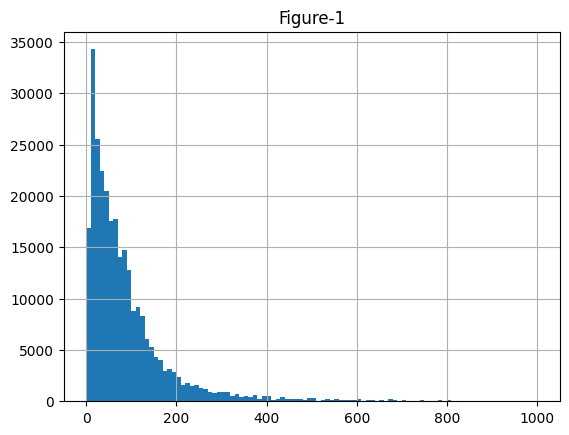

In [62]:
#Represent prices in dollar X-axis is price , Y-axis is number of listings
#I filtered the very big prices in this representations because it will distory the diagram
print(Listings['price'].describe())   # was used to print the statistical summary of the 
filtered_df_price = Listings[Listings['price'] < 1000] #was used to filter out the rows where the 'price' column is greater than or equal to 1000.
filtered_df_price['price'].hist(bins = 100) # was used to plot a histogram of the 'price' column of the filtered dataframe.
plt.title("Figure-1")
plt.show()

# Date understanding

In [63]:
def update_nan_values(row,columns_name, value):
  """This function is to update null values with a value"""

  if type(row[columns_name]) is float and np.isnan(row[columns_name]) :
    return value
  else: 
    return row[columns_name]

In [64]:
#This code is used to print the minimum and maximum date from the 'date' column of the Reviews dataset
print(Reveiws['date'].min())
print(Reveiws['date'].max())

2008-11-16
2021-03-01


In [65]:
# remove all nan values from the dataset on host_since field
Listings_filtered = Listings.copy()
null_value_update = '2014-07-31'
Listings_filtered['host_since'] = Listings_filtered.apply(lambda row: update_nan_values(row,'host_since',null_value_update), axis=1)

print(Listings_filtered['host_since'].min())
print(Listings_filtered['host_since'].max())

2008-08-12
2021-02-26


The code creates a list of years and defines a function that extracts the year from a given date column in a DataFrame, and then groups the filtered Listings and Reviews DataFrames by year using this function.

In [66]:
years=['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']

def grouping_by_date_yearly(row,column_name,df):
  year , _ , _ = df[column_name][row].split("-")
  return year
grouped_Listings_filtered = Listings_filtered.groupby(lambda row: grouping_by_date_yearly(row,'host_since',Listings_filtered))
grouped_Reveiws = Reveiws.groupby(lambda row: grouping_by_date_yearly(row,'date',Reveiws))



I splitted data based on year to see the distrubution of reviews and listing based on year

In [67]:
year_based_R_df={}
year_based_L_df={}
for i in years:
  year_based_R_df[i] = grouped_Reveiws.get_group(i)
  year_based_L_df[i] = grouped_Listings_filtered.get_group(i)
  print(i)
  print("Reviews Example: ",year_based_R_df[i]['date'].head(1))
  print("")
  print("Listing Example:",year_based_L_df[i]['host_since'].head(1))
  print("\n")

2008
Reviews Example:  4623201    2008-11-16
Name: date, dtype: object

Listing Example: 27149    2008-09-19
Name: host_since, dtype: object


2009
Reviews Example:  330335    2009-06-30
Name: date, dtype: object

Listing Example: 3314    2009-10-28
Name: host_since, dtype: object


2010
Reviews Example:  330340    2010-02-07
Name: date, dtype: object

Listing Example: 337    2010-09-06
Name: host_since, dtype: object


2011
Reviews Example:  330347    2011-04-20
Name: date, dtype: object

Listing Example: 0    2011-12-03
Name: host_since, dtype: object


2012
Reviews Example:  330356    2012-01-29
Name: date, dtype: object

Listing Example: 21    2012-11-18
Name: host_since, dtype: object


2013
Reviews Example:  330364    2013-01-25
Name: date, dtype: object

Listing Example: 1    2013-11-29
Name: host_since, dtype: object


2014
Reviews Example:  330375    2014-01-07
Name: date, dtype: object

Listing Example: 2    2014-07-31
Name: host_since, dtype: object


2015
Reviews Example:  

This code calculates the number of reviews and listings for each year between 2008 and 2020 and plots the data on a line chart with the title "Figure-2".

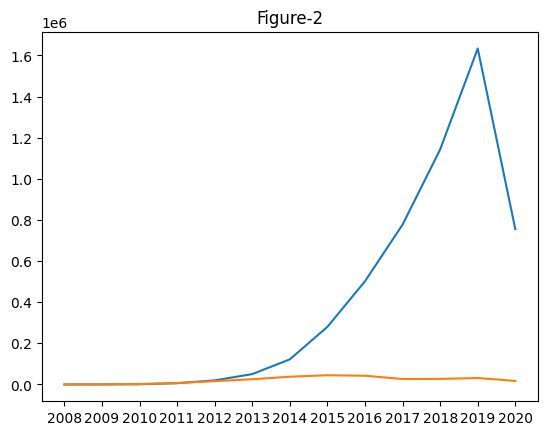

In [68]:
year_based_R_len = []
year_based_L_len = []
for year in years:
  year_based_R_len.append(len(year_based_R_df[year]))
  year_based_L_len.append(len(year_based_L_df[year]))
plt.plot(years,year_based_R_len)
plt.plot(years,year_based_L_len)
plt.title("Figure-2")
plt.show()

# Crossing between calender and listings

In [69]:
currency_changed_calender = 0
Paris_calinder = pd.read_csv('/content/Paris-calendar-2021.csv')

# basic understanding of Paris-calendar dataset

In [70]:
Paris_calinder.shape

(23610091, 7)

In [71]:
Paris_calinder.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [72]:
Paris_calinder.dtypes.values

array([dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'),
       dtype('float64'), dtype('float64')], dtype=object)

In [73]:
print(Paris_calinder['listing_id'].nunique()) # Count the number of unique listing_id values
Paris_calinder.head(10)

64677


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,11170,2021-02-13,f,$75.00,$75.00,2.0,1125.0
1,55239,2021-02-13,f,$360.00,$353.00,2.0,1125.0
2,55239,2021-02-14,t,$360.00,$353.00,2.0,1125.0
3,55239,2021-02-15,t,$360.00,$353.00,2.0,1125.0
4,55239,2021-02-16,t,$360.00,$353.00,2.0,1125.0
5,55239,2021-02-17,t,$360.00,$360.00,2.0,1125.0
6,55239,2021-02-18,t,$360.00,$360.00,2.0,1125.0
7,55239,2021-02-19,t,$360.00,$360.00,2.0,1125.0
8,55239,2021-02-20,t,$360.00,$360.00,2.0,1125.0
9,55239,2021-02-21,t,$360.00,$360.00,2.0,1125.0


In [74]:
paris_ids=[]
for index, row in Listings_filtered.iterrows(): # Iterate through each row of Listings_filtered
  if (row['listing_id'] in Paris_calinder['listing_id']) and (row['city']=='Paris'): # Check if the listing ID is in the Paris calendar and the city is Paris
    paris_ids.append(row['listing_id']) # If it is, add the listing ID to the paris_ids list
print(len(paris_ids))

31942


In [75]:
#to make sure that the calender contain data for the same listing_id in listings dataset
#I compared both prices after converting the caleder dataset prices to dollar too 
row1 = Listings[Listings['listing_id']==paris_ids[100]]
print(row1['price'])
row2 = Paris_calinder[Paris_calinder['listing_id']==paris_ids[100]]
_,price_ex = row2['price'].values[0].split('$')

print(float(price_ex)* X_to_dollar['Paris'])

149    136.4
Name: price, dtype: float64
136.4


In [76]:
#The next section is much faster with the same result
"""number_of_nights_per_id = {}
for index, row in Paris_calinder.iterrows():
  if row['available']=='f':
    if row['listing_id'] in number_of_nights_per_id:
      number_of_nights_per_id[row['listing_id']]  += 1
    else:
      number_of_nights_per_id[row['listing_id']] = 1
"""

"number_of_nights_per_id = {}\nfor index, row in Paris_calinder.iterrows():\n  if row['available']=='f':\n    if row['listing_id'] in number_of_nights_per_id:\n      number_of_nights_per_id[row['listing_id']]  += 1\n    else:\n      number_of_nights_per_id[row['listing_id']] = 1\n"

iterating through each row of a DataFrame called Paris_calinder and counting the number of nights that each listing ID is available.

In [77]:
number_of_nights_per_id1 = {}
j=0
for row in Paris_calinder.itertuples(index=False):
  j+=1
  if j%1000000 == 0:
    print(j)
  if row[2]=='f':
    if row[0] in number_of_nights_per_id1:
      number_of_nights_per_id1[row[0]]  += 1
    else:
      number_of_nights_per_id1[row[0]] = 1
  elif row[2]!='f' and row[0] not in number_of_nights_per_id1:
     number_of_nights_per_id1[row[0]] = 0

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000


In [78]:
#getting only the listing_ids that is exist in our listing dataset
number_of_nights_per_id_filtered = number_of_nights_per_id1.copy()

print(len (number_of_nights_per_id_filtered))
for id in number_of_nights_per_id1:
  if id not in paris_ids:
    del number_of_nights_per_id_filtered[id]
print(len (number_of_nights_per_id_filtered))

64677
31942


31942


(array([ 3504.,   347.,   425.,   180.,   187.,   196.,   309.,   137.,
          132.,    94.,   204.,    93.,   110.,   204.,   210.,    87.,
           87.,    57.,   241.,    96.,    65.,    36.,   116.,    86.,
           54.,   682.,   177.,   203.,    50.,    60.,    72.,   163.,
           55.,    65.,    77.,   121.,    60.,   924.,   218.,   220.,
          106.,   117.,    78.,   475.,   119.,   102.,    71.,   224.,
          169., 20077.]),
 array([  0.  ,   7.36,  14.72,  22.08,  29.44,  36.8 ,  44.16,  51.52,
         58.88,  66.24,  73.6 ,  80.96,  88.32,  95.68, 103.04, 110.4 ,
        117.76, 125.12, 132.48, 139.84, 147.2 , 154.56, 161.92, 169.28,
        176.64, 184.  , 191.36, 198.72, 206.08, 213.44, 220.8 , 228.16,
        235.52, 242.88, 250.24, 257.6 , 264.96, 272.32, 279.68, 287.04,
        294.4 , 301.76, 309.12, 316.48, 323.84, 331.2 , 338.56, 345.92,
        353.28, 360.64, 368.  ]),
 <BarContainer object of 50 artists>)

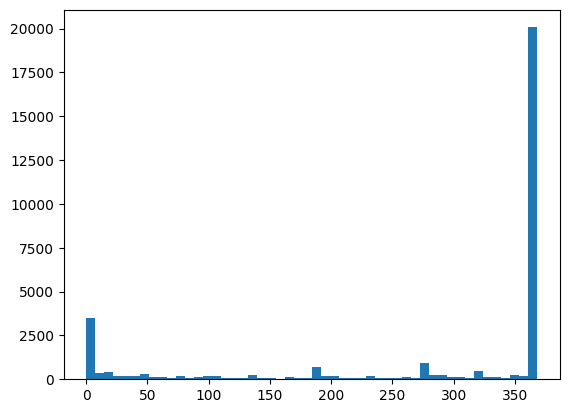

In [79]:
# ploting the distribution of the number of days in one year that each listing is full
values = list(number_of_nights_per_id_filtered.values())
print(len(number_of_nights_per_id_filtered))
plt.hist(values, bins=50)

**preprocess the listing dataset**

In [80]:
# drop the data which is not paris
Listing_paris_filter = Listings_filtered.copy()
Listing_paris_filter = Listing_paris_filter.drop(Listing_paris_filter[Listing_paris_filter['city'] != 'Paris'].index)
print("With all Ids",len(Listing_paris_filter))
Listing_paris_filter = Listing_paris_filter[Listing_paris_filter['listing_id'].isin(paris_ids)]
print("With only shared Ids",len(Listing_paris_filter))
Listing_paris_filter['city'].head(100)

With all Ids 64690
With only shared Ids 31942


0      Paris
1      Paris
2      Paris
3      Paris
4      Paris
       ...  
144    Paris
145    Paris
146    Paris
147    Paris
148    Paris
Name: city, Length: 100, dtype: object

In [81]:
for i in paris_ids:
  if i not in Listing_paris_filter['listing_id'].values:
    print(1)
for i in Listing_paris_filter['listing_id']:
  if i not in paris_ids:
    print(22)
for i in paris_ids:
  if i not in number_of_nights_per_id_filtered:
    print(33)
print(Listing_paris_filter['listing_id'])

0           281420
1          3705183
2          4082273
3          4797344
4          4823489
            ...   
279636    22980552
279637    23016641
279638    23103869
279639    23227926
279640    23552264
Name: listing_id, Length: 31942, dtype: int64


In [82]:
Listing_paris_filter['nights_reserved'] = None
for index, row in Listing_paris_filter.iterrows():
  id = row['listing_id']
  x = number_of_nights_per_id_filtered[id]
  Listing_paris_filter['nights_reserved'][index] = x
print(Listing_paris_filter['nights_reserved'].head(3))

<ipython-input-82-63c94e4972c5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Listing_paris_filter['nights_reserved'][index] = x


0    365
1    365
2    365
Name: nights_reserved, dtype: object


31942


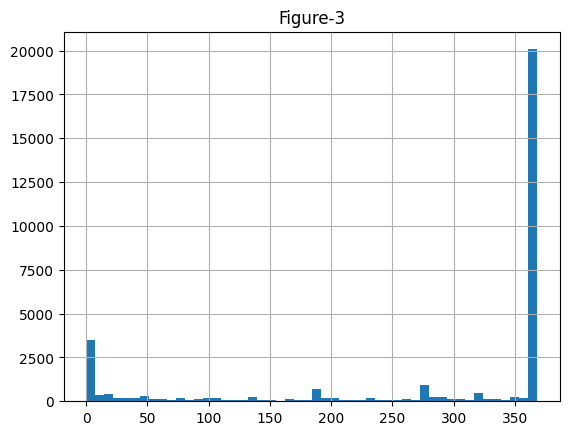

In [83]:
# finally as we see here the distubution of number of nights reservened in paris at 2021 is very real and similar to the distubution that we saw before
print(len(Listing_paris_filter))
Listing_paris_filter['nights_reserved'].hist(bins=50)
plt.title("Figure-3")
plt.show()

**calculating profit and assign it as column**

In [84]:
def profit_calculater(number_of_nights, price):
  return int(number_of_nights * price)
Listing_paris_filter['profit'] = None
for index, row in Listing_paris_filter.iterrows():
  #Listing_paris_filter['profit'] = Listing_paris_filter['nights_reserved'] * Listing_paris_filter['price']
  Listing_paris_filter['profit'][index] = profit_calculater(row['nights_reserved'],row['price'])

<ipython-input-84-67f5c8f8868c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Listing_paris_filter['profit'][index] = profit_calculater(row['nights_reserved'],row['price'])


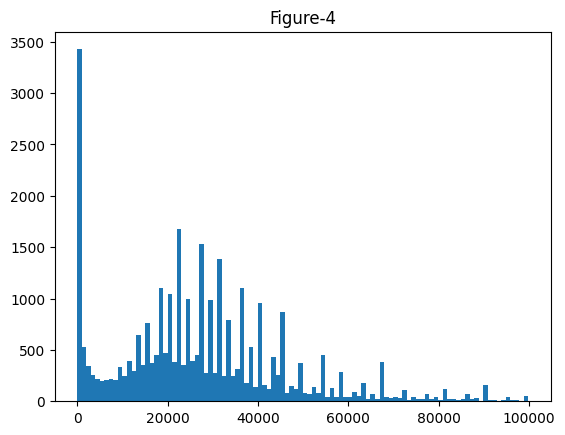

In [85]:
# ploting the distubution of profit between listings 
# of course there will be alot of listing (~3400) with no profit at all and that what we gonna fix it 
profit_for_plotting =[]
profit_count ={}
for i in Listing_paris_filter['profit']:
  if i in profit_count:
    profit_count[i] += 1
  else:
    profit_count[i] = 1
  if i< 100000:
    profit_for_plotting.append(i)
plt.hist(profit_for_plotting,bins=100)
plt.title("Figure-4")
plt.show()

# **Removing the unused columns and continue preprocessing**

In [86]:
L_dataset = Listing_paris_filter.copy()
L_dataset.columns

Index(['listing_id', 'name', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'district', 'city', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bedrooms', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'nights_reserved', 'profit'],
      dtype='object')

In [87]:
if 'host_id' in L_dataset.columns:
  L_dataset = L_dataset.drop('host_id', axis=1)
if 'district' in L_dataset.columns:
 L_dataset = L_dataset.drop('district', axis=1)
if 'host_location' in  L_dataset.columns:
  L_dataset = L_dataset.drop('host_location', axis=1)
if 'host_response_time' in  L_dataset.columns:
  L_dataset = L_dataset.drop('host_response_time', axis=1)
if 'host_response_rate' in  L_dataset.columns:
  L_dataset = L_dataset.drop('host_response_rate', axis=1)
if 'host_acceptance_rate' in  L_dataset.columns:
  L_dataset = L_dataset.drop('host_acceptance_rate', axis=1)
if 'host_response_rate' in  L_dataset.columns:
  L_dataset = L_dataset.drop('host_response_rate', axis=1)
if 'host_has_profile_pic' in  L_dataset.columns:
  L_dataset = L_dataset.drop('host_has_profile_pic', axis=1)
if 'host_identity_verified' in  L_dataset.columns:
  L_dataset = L_dataset.drop('host_identity_verified', axis=1)
if 'neighbourhood' in  L_dataset.columns:
  L_dataset = L_dataset.drop('neighbourhood', axis=1)
if 'name' in  L_dataset.columns:
  L_dataset = L_dataset.drop('name', axis=1)



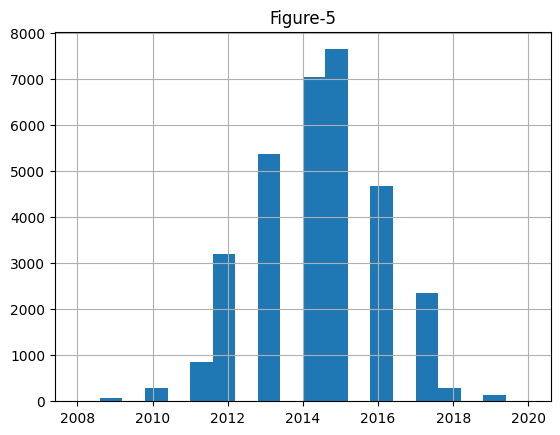

In [88]:
def update_date_host_since_to_int(row,columns_name, value):
  """This function is to update date from full representation to int year"""
  if type(row[columns_name]) is int:
    return row[columns_name]
  return int(row['host_since'][0:4])
L_dataset['host_since'] = L_dataset.apply(lambda row: update_date_host_since_to_int(row,'host_since',0), axis=1)
L_dataset['host_since'].hist(bins=20)
plt.title("Figure-5")
plt.show()

encoding host_is_superhost

<Axes: >

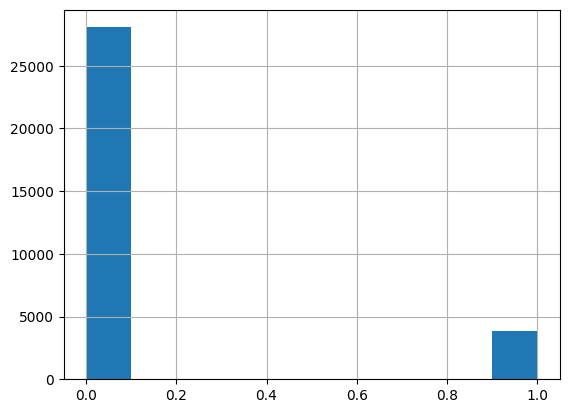

In [89]:
def update_ordinal_encoder_to_bool(row,column):
  """Ordinal encoding column"""
  if type(row[column]) is bool:
    return row[column]
  if row[column] == 'f':
    return 0
  else:
    return 1
# encoding host_is_superhost
L_dataset['host_is_superhost'] = Listings.apply(lambda  row : update_ordinal_encoder_to_bool(row,'host_is_superhost'), axis = 1)
L_dataset['host_is_superhost'].hist(bins=10)

# One hot encoding 

In [90]:
def One_Hot_Encoder_function(dataset , column):
  """This Function to One hot encode any column"""
  if column not in dataset.columns:
    return dataset
  One_Hot_Encoder = OneHotEncoder()
  one_hot_encoded = pd.get_dummies(dataset[column], prefix=column)
  one_hot_encoded_df = pd.concat([dataset, one_hot_encoded], axis=1)
  one_hot_encoded_df = one_hot_encoded_df.drop(column, axis=1)
  return one_hot_encoded_df


In [91]:
# encoding property_type
print(L_dataset['property_type'].unique())
print(len(L_dataset.columns))
L_dataset_E1 = One_Hot_Encoder_function(L_dataset,'property_type')
print (len(L_dataset_E1.columns))
print(L_dataset_E1.columns)

['Entire apartment' 'Entire loft' 'Entire house'
 'Private room in apartment' 'Entire condominium' 'Earth house'
 'Entire townhouse' 'Room in serviced apartment'
 'Entire serviced apartment' 'Private room in house' 'Entire villa'
 'Private room in guest suite' 'Private room in condominium'
 'Private room in loft' 'Entire guest suite' 'Entire place'
 'Room in boutique hotel' 'Entire floor' 'Entire guesthouse' 'Houseboat'
 'Entire cottage' 'Boat' 'Tiny house' 'Private room in guesthouse'
 'Entire home/apt' 'Room in bed and breakfast'
 'Private room in bed and breakfast' 'Private room in villa'
 'Room in aparthotel' 'Private room in chalet' 'Entire bed and breakfast'
 'Private room in townhouse' 'Shared room in apartment' 'Cave'
 'Private room in boat' 'Private room' 'Private room in earth house'
 'Shared room in condominium' 'Room in hotel'
 'Private room in serviced apartment' 'Shared room in loft'
 'Private room in houseboat' 'Shared room in house'
 'Shared room in townhouse' 'Shared r

In [92]:
# encoding room_type
print(L_dataset_E1['room_type'].unique())
L_dataset_E2 = One_Hot_Encoder_function(L_dataset_E1,'room_type')
print(len(L_dataset_E2.columns))
print(L_dataset_E2.columns)

['Entire place' 'Private room' 'Hotel room' 'Shared room']
80
Index(['listing_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'city', 'latitude', 'longitude',
       'accommodates', 'bedrooms', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'nights_reserved', 'profit',
       'property_type_Boat', 'property_type_Cave', 'property_type_Dome house',
       'property_type_Earth house', 'property_type_Entire apartment',
       'property_type_Entire bed and breakfast',
       'property_type_Entire condominium', 'property_type_Entire cottage',
       'property_type_Entire floor', 'property_type_Entire guest suite',
       'property_type_Entire guesthouse', 'property_type_Entire home/apt',
       'property_type_Entire house', '

<Axes: >

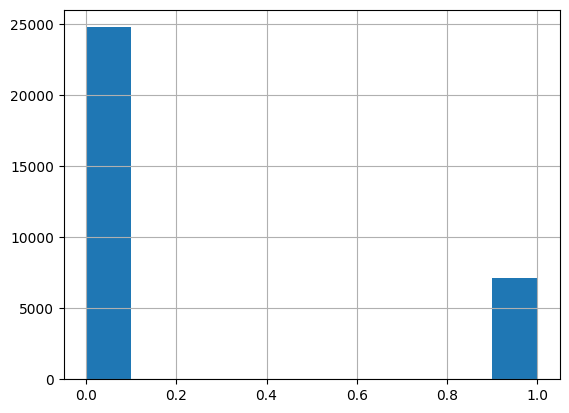

In [93]:
# encoding instant_bookable
L_dataset_E2['instant_bookable'] = Listings.apply(lambda  row : update_ordinal_encoder_to_bool(row,'instant_bookable'), axis = 1)
L_dataset_E2['instant_bookable'].hist(bins=10)

# **Amenities Encoding**

Unfortunately amenities are saved as a json, but read_csv recognizes only a string. In the first step we will split the string in parts and using regular expressions we will remove unnecessary characters. Then we will encode amenities as dummy variables



In [94]:
amenities = L_dataset_E2["amenities"].str.split(",",expand=True)
amenities.head(3)

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,"[""Heating""","""Kitchen""","""Washer""","""Wifi""","""Long term stays allowed""]",None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"[""Shampoo""","""Heating""","""Kitchen""","""Essentials""","""Washer""","""Dryer""","""Wifi""","""Long term stays allowed""]",None,None,...,None,None,None,None,None,None,None,None,None,None
2,"[""Heating""","""TV""","""Kitchen""","""Washer""","""Wifi""","""Long term stays allowed""]",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


The first line is using the "replace" method on the "amenities" dataframe to replace any non-word and non-space characters with an empty string (i.e., removing them from the strings in the dataframe).
The second line is creating a list called "amenities_list" that contains the unique values of each column in the "amenities" dataframe (as a list) using a list comprehension and the "unique" and "tolist" methods.
The third line is flattening the nested list structure of "amenities_list" using the "chain.from_iterable" method from the "itertools" library, converting the resulting iterable to a list, and then creating a set from that list. This essentially creates a set of all unique values across all columns in the "amenities" dataframe.
The fourth line is removing any empty strings or None values from the set of unique values.

In [95]:
amenities = amenities.replace(regex=["[^\w\s]"], value="")
amenities_list = [amenities[item].unique().tolist() for item in amenities.columns.values]
amenities_list = set(list(chain.from_iterable(amenities_list)))
amenities_list.remove('')
amenities_list.remove(None) 

In [96]:
amenities_list

{' 1 space',
 ' 103 TV with Netflix',
 ' 2 fours Microonde et chaleur tournante stainless steel oven',
 ' 23 HDTV with premium cable',
 ' 32 HDTV',
 ' 40 HDTV with Netflix',
 ' 41 HDTV with standard cable',
 ' 42 HDTV with Netflix',
 ' 45 HDTV with Netflix',
 ' 48 HDTV with premium cable',
 ' 55 HDTV with Netflix',
 ' 60 HDTV',
 ' AESOP shampoo',
 ' Aderma body soap',
 ' Aesop  body soap',
 ' Aesop  conditioner',
 ' Aesop conditioner',
 ' Aesop shampoo',
 ' Air conditioning',
 ' Alarm system',
 ' Amazon Prime Video',
 ' Amu00e9ricain refrigerator',
 ' Apple  Bluetooth sound system',
 ' BBQ grill',
 ' Baby bath',
 ' Baby monitor',
 ' Baby safety gates',
 ' Babysitter recommendations',
 ' Baking sheet',
 ' Balcony',
 ' Bang  Olufsen Bluetooth sound system',
 ' Barbecue utensils',
 ' Bathroom essentials',
 ' Bathtub',
 ' Beach essentials',
 ' Beachfront',
 ' Bed linens',
 ' Bedroom comforts',
 ' Bikes',
 ' Blender',
 ' BluRay player',
 ' Bluetooth sound system',
 ' Board games',
 ' Body s

In [97]:
len(amenities_list)

479

In [98]:
for items in amenities_list:
    L_dataset_E2[items] = L_dataset_E2["amenities"].apply(lambda x: 1 if items in x else 0)

<ipython-input-98-36dc8c5ed2be>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  L_dataset_E2[items] = L_dataset_E2["amenities"].apply(lambda x: 1 if items in x else 0)
<ipython-input-98-36dc8c5ed2be>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  L_dataset_E2[items] = L_dataset_E2["amenities"].apply(lambda x: 1 if items in x else 0)
<ipython-input-98-36dc8c5ed2be>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [99]:
len(L_dataset_E2.columns)

559

In [100]:
L_dataset_E2.drop(columns="amenities",inplace=True)

In [101]:
if 'city' in  L_dataset_E2.columns:
  L_dataset_E2 = L_dataset_E2.drop('city', axis=1)

In [102]:
print(len(L_dataset_E2))
print(L_dataset_E2.dtypes)

31942
listing_id                                       int64
host_since                                       int64
host_is_superhost                                int64
host_total_listings_count                      float64
latitude                                       float64
                                                ...   
 LOru00e9al conditioner                          int64
 seb oven                                        int64
 Extra pillows and blankets                      int64
 Dining area for 4 people                        int64
 Paid parking lot on premises u2013 1 space      int64
Length: 557, dtype: object


Finally we got dataset with 561 feature and 31942 columns and one target which is the profit

In [103]:
# removing nights_reserved column but we should keep price columns
if 'nights_reserved' in  L_dataset_E2.columns:
  L_dataset_E2 = L_dataset_E2.drop('nights_reserved', axis=1)

In [244]:
L_dataset_E3 = L_dataset_E2.copy()

In [245]:
#L_dataset_E3 = L_dataset_E3.drop('price', axis=1)

In [246]:
L_dataset_E3 = L_dataset_E3[L_dataset_E3['profit']!=0]
L_dataset_E3 = L_dataset_E3[L_dataset_E3['profit']<=40000]
L_dataset_E3 = L_dataset_E3[L_dataset_E3['profit']>=10000]

In [247]:
print(len(L_dataset_E3))

18377


# Modeling

plitting a dataset into training and testing sets using the train_test_split function from the scikit-learn library.

In [248]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(L_dataset_E3)
L_dataset_E3 = imputed_data = imputer.transform(L_dataset_E3)
L_dataset_E3 = pd.DataFrame(L_dataset_E3, columns = L_dataset_E2.columns)

In [249]:
L_dataset_E3.head(1)

,listing_id,host_since,host_is_superhost,host_total_listings_count,latitude,longitude,accommodates,bedrooms,price,minimum_nights,...,Paid parking garage on premises u2013 680 spaces,Petit marseillais body soap,Savon liquide Petit Marseillais body soap,petit marseillais bio body soap,Hot water,LOru00e9al conditioner,seb oven,Extra pillows and blankets,Dining area for 4 people,Paid parking lot on premises u2013 1 space
0,281420.0,2011.0,0.0,1.0,48.88668,2.33343,2.0,1.0,65.72,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [250]:
X_train, X_test, y_train, y_test = train_test_split(L_dataset_E3.copy().drop('profit', axis=1), L_dataset_E3['profit'], test_size=0.2)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

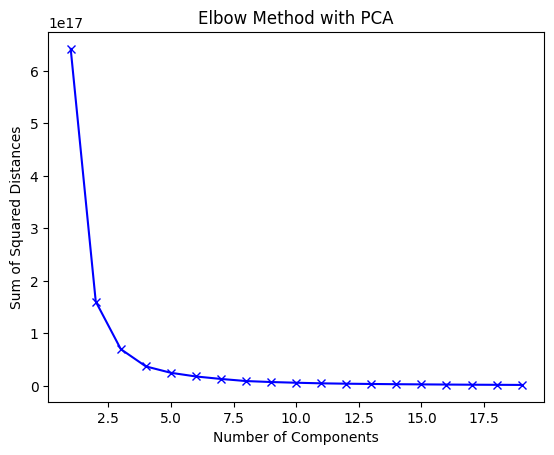

In [111]:
from sklearn.cluster import KMeans

# create an instance of SimpleImputer with the desired strategy (e.g. mean, median, most_frequent)
imputer = SimpleImputer(strategy='most_frequent')

# fit the imputer to the feature set with missing values
imputer.fit(X_train)

# transform the feature set by filling in the missing values
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Fit PCA to data
pca = PCA()
pca.fit(X_train_imputed)

# Transform data to obtain principal components
X_pca = pca.transform(X_train_imputed)

# Iterate over a range of values for number of components
ssd = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca[:,:i])
    ssd.append(kmeans.inertia_)

# Plot the sum of squared distances for each number of components
plt.plot(range(1,20), ssd, 'bx-')
plt.xlabel('Number of Components')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method with PCA')
plt.show()






In [112]:
"""pipeline1 = make_pipeline(
    SimpleImputer(strategy="mean"),  # Impute missing values with mean
    StandardScaler(),  # Scale features to have mean=0 and variance=1
    PCA(n_components=10)
)
model = pipeline1.fit(X_train, y_train)"""

'pipeline1 = make_pipeline(\n    SimpleImputer(strategy="mean"),  # Impute missing values with mean\n    StandardScaler(),  # Scale features to have mean=0 and variance=1\n    PCA(n_components=10)\n)\nmodel = pipeline1.fit(X_train, y_train)'

In [113]:
from sklearn.linear_model import LinearRegression
#pipeline = make_pipeline(
#    SimpleImputer(strategy="most_frequent"),  # Impute missing values with mean
    #StandardScaler(),  # Scale features to have mean=0 and variance=1
    #PCA(n_components=20),  # set the number of components
    #LinearRegression()
#    TPOTRegressor(generations=5, population_size=20 , verbosity=2)
#)
pipeline = TPOTRegressor(generations=5, population_size=20 , max_time_mins = 60, verbosity=2)
pipeline.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -18957264.955023475

Generation 2 - Current best internal CV score: -18957264.955023475

61.02 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=16, min_samples_split=19, n_estimators=100)


TPOTRegressor(generations=5, max_time_mins=60, population_size=20, verbosity=2)

early version
Best pipeline: RandomForestRegressor(LassoLarsCV(ElasticNetCV(input_matrix, l1_ratio=0.8500000000000001, tol=0.001), normalize=True), bootstrap=True, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=19, n_estimators=100)
score 0.65

This is best pipline without priceing profit between 10k and 40k and pca 20

# **60min no PCA mean Simple Imputer: **

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=16, min_samples_split=19, n_estimators=100)

score:0.67

In [137]:
pipeline.export("10-40-mean-60min.py")

In [142]:
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae:.2f}")
print(r2_score(y_test.tolist(),y_pred))

Mean absolute error: 2331.72
0.6751426639514115


# **Evaluation**

Best pipeline: RandomForestRegressor(LassoLarsCV(ElasticNetCV(input_matrix, l1_ratio=0.85, tol=0.001), normalize=True), bootstrap=True, max_features=0.35, min_samples_leaf=4, min_samples_split=19, n_estimators=100)

This is best pipline without priceing profit between 10k and 40k and pca 20

In [251]:
#Applying the best model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoLarsCV, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.metrics import r2_score

pipeline1 = make_pipeline(
    SimpleImputer(strategy="mean"),
    #PCA(n_components=20),
    RandomForestRegressor(
        bootstrap=False,
        max_features=0.75,
        min_samples_leaf=16,
        min_samples_split=19,
        n_estimators=100
    )
)
pipeline1.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline1.predict(X_test)

# Evaluate the performance of the pipeline using mean squared error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae:.2f}")
print(r2_score(y_test.tolist(),y_pred))

Mean absolute error: 2279.56
0.6846982191997325


As we can see here the Mean Abdolute Error is between 2300 and 3000 depending on the PCA components. how ever it is very good aproximation for the profits +-2500, which will lead to good depolyment in the folowing sections.

The folowing diagram show the difference between the distubution of the real profit and predicted one

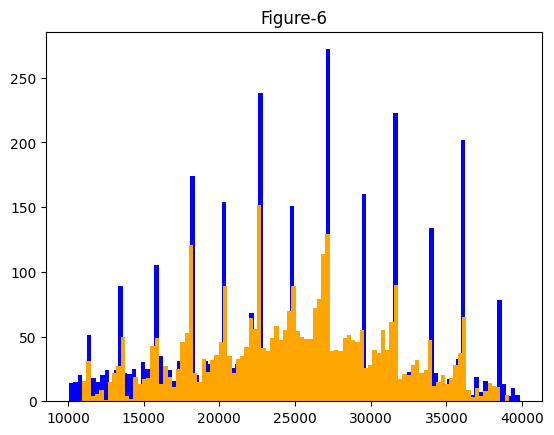

In [252]:
plt.hist(y_test.tolist(),bins=100,color="Blue")
plt.hist(y_pred.tolist(),bins=100,color="orange")
plt.title("Figure-6")
plt.show()

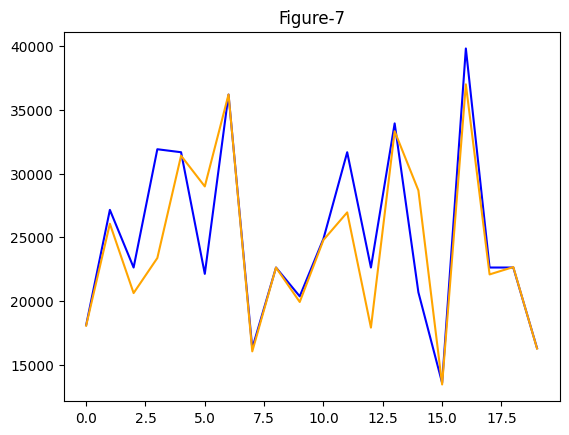

In [229]:
import random
random_indices = random.sample(range(len(y_test.tolist())), 20)
Y1 = [y_test.tolist()[i] for i in random_indices]
Y2 = [y_pred.tolist()[i] for i in random_indices]
plt.plot(Y1,color="Blue")
plt.plot(Y2,color="orange")
plt.title("Figure-7")
plt.show()

The minimum profit show as folowing

In [253]:
print(int(y_pred.min()))
np.min(y_test.tolist())

10939


10044.0

First 10 samples profits

In [254]:
for i in range(10):
  print(int(y_pred[i]),y_test.tolist()[i])

20355 20367.0
23422 23987.0
22309 22630.0
24541 13680.0
37867 38018.0
26411 12320.0
18883 19009.0
28143 29418.0
24854 24893.0
21357 21143.0


# **Depolyment**

### A Sample of A listing has low price and the owner should increase the price to increase his profit

lets study one sample that has very low MAE result 

In [255]:
X_sample= X_test.iloc[0]
y_sample = y_test.iloc[0]
f"price: {X_sample['price']}"

'price: 55.8'

In [256]:
y_sample_pred = pipeline1.predict(np.array(X_sample).reshape(1, -1))
f"predicted profit for this price: {y_sample_pred[0]}"

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


'predicted profit for this price: 20355.920642518'

In [257]:
f"Real Profit: {y_sample}"

'Real Profit: 20367.0'

In [258]:
#Calculating the profit with changing the price
y_sample_pred_list =[]
minimum_price=1
maximum_price=400 
for i in range(minimum_price,maximum_price):
  X_sample['price'] = i
  y_sample_pred = pipeline1.predict(pd.DataFrame(np.array(X_sample).reshape(1, -1),columns=X_test.columns))
  y_sample_pred_list.append(y_sample_pred[0])

In [259]:
f"Highest Profit is :{np.max(y_sample_pred_list)}"

'Highest Profit is :38947.18617342108'

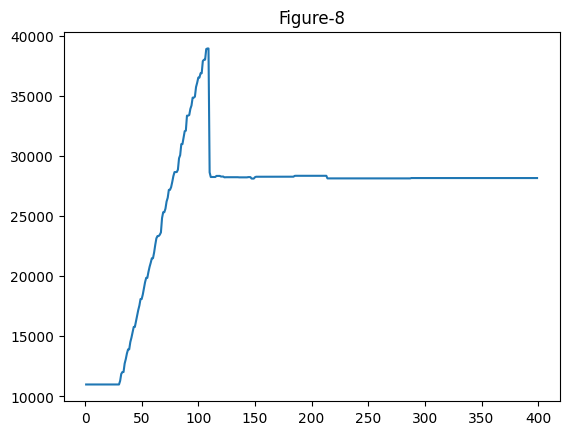

In [260]:
#ploting The profit on Y_axis and price on X_axis
X_axis= [i for i in range(minimum_price,maximum_price)]
plt.plot(X_axis,y_sample_pred_list)
plt.title("Figure-8")
plt.show()

In [261]:
print("details of this Sample: ")
for index, value in enumerate(X_test.iloc[2]):
  if value:
    print(X_test.columns[index],":", value)

details of this Sample: 
listing_id : 5275583.0
host_since : 2014.0
host_total_listings_count : 1.0
latitude : 48.85216
longitude : 2.36718
accommodates : 1.0
bedrooms : 1.0
price : 62.0
minimum_nights : 3.0
maximum_nights : 15.0
review_scores_rating : 94.0
review_scores_accuracy : 10.0
review_scores_cleanliness : 10.0
review_scores_checkin : 10.0
review_scores_communication : 9.0
review_scores_location : 10.0
review_scores_value : 9.0
property_type_Private room in apartment : 1.0
room_type_Private room : 1.0
Heating : 1.0
Kitchen : 1.0
Washer : 1.0
Indoor fireplace : 1.0
Dryer : 1.0
TV : 1.0
Wifi : 1.0
Essentials : 1.0


In [262]:
print("Best price for best profit is :",y_sample_pred_list.index(np.max(y_sample_pred_list)) )
print("profit will be:", np.max(y_sample_pred_list))

Best price for best profit is : 107
profit will be: 38947.18617342108


### A Sample of A listing has high price and the owner should decrease the price to increase his profit

Sample with very hight price and we want to reduce this price to get better profit

In [274]:
max_price_index = X_test['price'].idxmax()
max_price_row_num = X_test.index.get_loc(max_price_index)
f"price: {X_test['price'].max()}"

'price: 7999.0'

In [275]:
X_sample1= X_test.iloc[max_price_row_num]
y_sample1 = y_test.iloc[max_price_row_num]
f"price: {X_sample1['price']}"

'price: 7999.0'

In [276]:
y_sample1_pred = pipeline1.predict(np.array(X_sample1).reshape(1, -1))
f"Real Profit: {y_sample1} , Predicted Profit: {int(y_sample1_pred[0])}"

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


'Real Profit: 16368.0 , Predicted Profit: 17648'

In [277]:
#Calculating the profit with changing the price
y_sample1_pred_list =[]
minimum_price=1
maximum_price=8000 
for i in range(minimum_price,maximum_price):
  X_sample1['price'] = i
  y_sample1_pred = pipeline1.predict(pd.DataFrame(np.array(X_sample1).reshape(1, -1),columns=X_test.columns))
  y_sample1_pred_list.append(y_sample1_pred[0])

In [278]:
f"Highest Profit is :{np.max(y_sample1_pred_list)}"

'Highest Profit is :36095.25409158071'

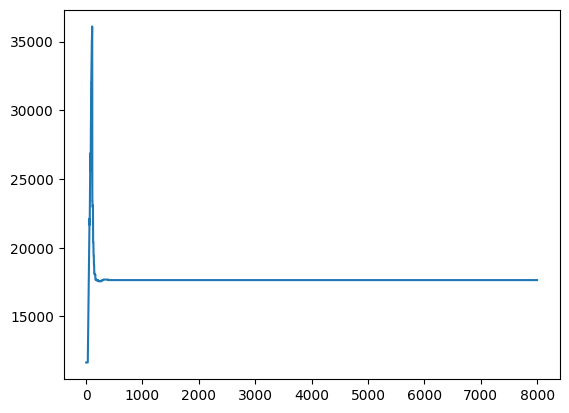

In [279]:
#ploting The profit on Y_axis and price on X_axis
X_axis= [i for i in range(minimum_price,maximum_price)]
plt.plot(X_axis,y_sample1_pred_list)

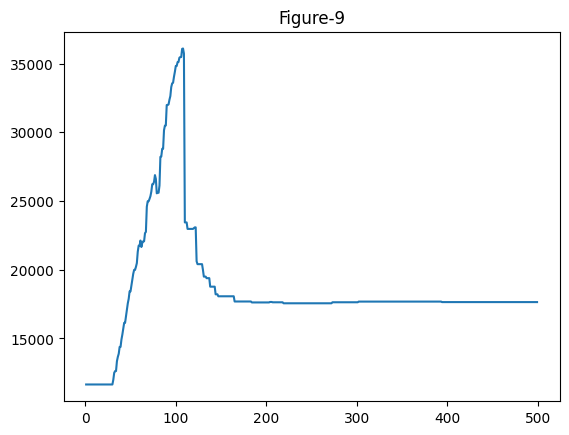

In [280]:
#ploting The profit on Y_axis and price on X_axis
X_axis= [i for i in range(minimum_price,500)]
plt.plot(X_axis,y_sample1_pred_list[:499])
plt.title("Figure-9")
plt.show()

In [281]:
print("details of this Sample: ")
for index, value in enumerate(X_test.iloc[max_price_row_num]):
  if value:
    print(X_test.columns[index], value)

details of this Sample: 
listing_id 20471163.0
host_since 2018.0
host_total_listings_count 15.0
latitude 48.86427
longitude 2.28641
accommodates 4.0
bedrooms 2.0
price 7999.0
minimum_nights 1.0
maximum_nights 1125.0
review_scores_rating 92.9905467372134
review_scores_accuracy 9.622137404580153
review_scores_cleanliness 9.166772666242668
review_scores_checkin 9.746710060846187
review_scores_communication 9.772797964088788
review_scores_location 9.58697806086341
review_scores_value 9.348029155756846
property_type_Entire villa 1.0
room_type_Entire place 1.0
Heating 1.0
Air conditioning 1.0
Kitchen 1.0
Washer 1.0
Dryer 1.0
TV 1.0
Wifi 1.0
Pool 1.0


In [282]:
print("Best price for best profit is :",y_sample1_pred_list.index(np.max(y_sample1_pred_list)) )
print("profit will be:", np.max(y_sample1_pred_list))

Best price for best profit is : 107
profit will be: 36095.25409158071


# **Getting the change in profit of the Data Mining**

Real total Profit vs predicted total profit

In [179]:
y_pred.sum() , y_test.sum() , len(X_test)

(91498387.07386541, 91808513.0, 3676)

In [187]:
def get_max_predicted_profit(X):
  #Calculating the profit with changing the price
  y_pred_list =[]
  minimum_price=1
  maximum_price=300 
  for i in range(minimum_price,maximum_price,10):
    X['price'] = i
    y_pred = pipeline1.predict(pd.DataFrame(np.array(X).reshape(1, -1),columns=X_test.columns))
    y_pred_list.append(y_pred[0])
  return np.max(y_pred_list)

In [ ]:
maximum_total_predicted_profit=[]
for i in range(len(X_test)):
  print(i)
  max_profit = get_max_predicted_profit(X_test.iloc[i])
  maximum_total_predicted_profit.append(max_profit)


2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940


In [189]:
len(maximum_total_predicted_profit)

3676

In [196]:
f"total predicted maximum profit: {np.sum(maximum_total_predicted_profit)}"

'total predicted maximum profit: 124012677.58384113'

In [197]:
f"total diference between old profit and new profit: {int(np.sum(maximum_total_predicted_profit)-y_test.sum())}"

'total diference between old profit and new profit: 32204164'

In [201]:
Rate_of_increasing = int(np.sum(maximum_total_predicted_profit)-y_test.sum())*100/y_test.sum()
f"The percentage increasment in the profit is : {int(Rate_of_increasing)}%"

'The percentage increasment in the profit is : 35%'

In [203]:
Error = len(X_test)*2000
f"Error +-{Error}"

'Error +-7352000'

In [206]:
lowest_profit_percentage = (int(np.sum(maximum_total_predicted_profit)-y_test.sum())-Error)*100/y_test.sum()
maximum_profit_percentage = (int(np.sum(maximum_total_predicted_profit)-y_test.sum())+Error)*100/y_test.sum()
f"The percentage increasment in the profit is between : {int(lowest_profit_percentage)}% - {int(maximum_profit_percentage)}%"

'The percentage increasment in the profit is between : 27% - 43%'

The business Goal is achieved with 27% - 43% profit

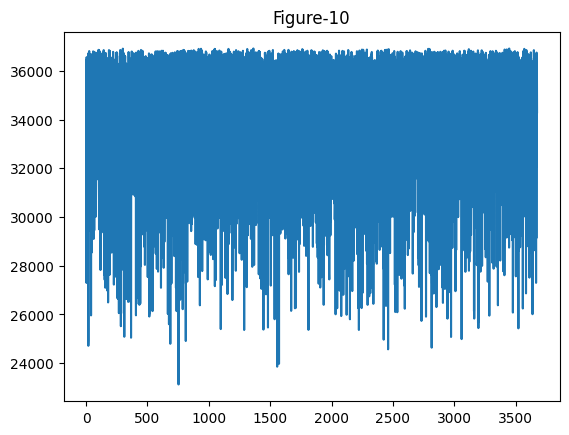

In [283]:
#ploting The max profit on Y_axis and listing index on X_axis
X_axis= [i for i in range(0,3676)]
plt.plot(X_axis,maximum_total_predicted_profit)
plt.title("Figure-10")
plt.show()

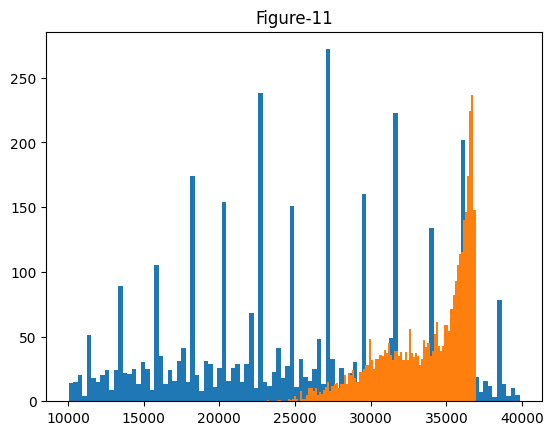

In [284]:
plt.hist(y_test,bins=100)
plt.hist(maximum_total_predicted_profit,bins=100)
plt.title("Figure-11")
plt.show()